# t-SNE vs. PCA y MDS en la base de datos Fashion-MNIST

Vamos a trabajar en esta práctica con t-SNE comparándolo otra vez con reductores de dimensionalidad de tipo lineal como son PCA y MDS sobre imágenes. Esta vez, en lugar de usar el clásico repositorio MNIST, vamos a utilizar otro que se considera una evolución del anterior: Fashion-MNIST. Este es un dataset con 70000 productos de ropa y complementos en forma de fotos de 28x28 en escala de grises. Existen 10 categorias de productos con 7000 imágenes por categoria. El training set tiene 60000 imagenes y el test set tiene 10000. Los miembros del dataset están etiquetados de la siguiente manera:

0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot

La siguiente caja define una función para cargar los ficheros comprimidos que se te proporcionan, de nombres train-images-idx3-ubyte.gz y train-labels-idx1-ubyte.gz

(60000, 784)
Populating the interactive namespace from numpy and matplotlib


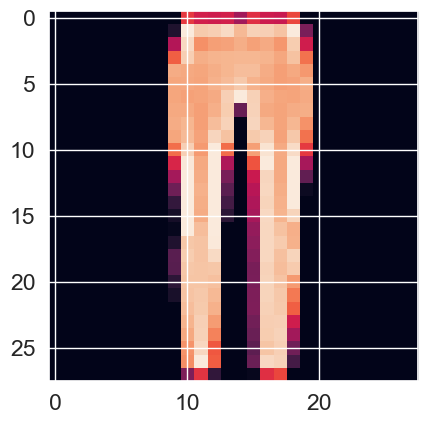

In [6]:
import numpy as np
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

#Pon aquí el path dondde has alojado las imágenes. 
#Si estas en windows y estan en el mismo directorio que el Notebook, este path funciona
path = './'
X_train, y_train = load_mnist(path, kind='train')

#la talla debe salirte (60000, 784)
print(X_train.shape)

%pylab inline
#visualizamos una imagen para ver su aspecto
imgplot = plt.imshow(np.reshape(X_train[12457],(28,28)))
plt.show()

Importamos las librerias necesarias

In [7]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
#semilla para mantener reproducibilidad
RS = 123

Para visualizar los resultados se te proporcionan dos funciones. La primera 'fashion_scatter' pintará el resultado del mapeado 2D como puntos coloreados con un color distinto para cada etiqueta (de 1 a 10). Tiene dos argumentos: el primero es un array numpy 2D que contiene los datos resultados del algoritmo (PCA o t-SNE). El segudo es un array de colores que contiene los colores de las etiquetas.

La segunda función plot_components es parecida a la función de la práctica anterior. Muestra el los puntos en el mapa 2D de color negro y saca algunos representantes en forma de fotos eligiendo puntos al azar (homogeneamente)

In [8]:
# Utility function to visualize the outputs of PCA and t-SNE

def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

# source: https://jakevdp.github.io/PythonDataScienceHandbook/05.10-manifold-learning.html
def plot_components(data,images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = data
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(np.reshape(images[i],(28,28)), cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

Para estar seguros de que no colapsamos el ordenador, vamos a elegir solo 2000 ejempos del dataset. Primero baraja el dataset (shuffle)para asegurarte de están homogeneamente repartidos

In [9]:
#Baraja aquí el dataset X_train y asegurate de que hay correspondencia con y_train
np.random.seed(RS)
idx_random_train = np.random.randint(0, len(X_train), size = 1000)

#Subset first 20k data points to visualize
x_subset = X_train[0:2000]
y_subset = y_train[0:2000]

print(np.unique(y_subset))

[0 1 2 3 4 5 6 7 8 9]


Vamos a usar primero PCA (método lineal) para tratar el problema. Vamos a usar PCA con n_components=4 para obtener proyecciones en un espacio 4D y ver cómo se distribuye la cantida de varianza que explica cada dimensión. Puedes dejar el resto de parametros por defecto o jugar un poco con ellos sobre la base de los parámetros por defecto

In [10]:
from sklearn.decomposition import PCA

time_start = time.time()
#Configura la PCA para cuatro componentes. Puedes jugar con alguno de los parámetros
pca = PCA(n_components=4)
pca_result = pca.fit_transform(x_subset)

#imprime el atributo que explica la ratio de varianza
print('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

Variance explained per principal component: [0.29415547 0.18213408 0.0585316  0.05250544]


Observa arriba la varianza explicada por los cuatro primeros  componentes principales.

Vamos a almacenar los cuatro primeros componentes principales (cuatro primeros autovectores) en un nuevo DataFrame
Now you will store all the four principal components in a new DataFrame pca_df and check the amount of variance of the data explained by these four components.

In [11]:
pca_df = pd.DataFrame(columns = ['pca1','pca2','pca3','pca4'])

pca_df['pca1'] = pca_result[:,0]
pca_df['pca2'] = pca_result[:,1]
pca_df['pca3'] = pca_result[:,2]
pca_df['pca4'] = pca_result[:,3]



**Actividad 1** Justifica aquí en función de los porcentajes de varianza explicada si es coherente quedarnos con únicamente las dos primeras dimensiones. Piensa que los valores están ordenados en forma decreciente y que ningun valor de los restantes supera el valor del cuarto.

<font color='blue'>
La suma de las dos primeras dimensiones es de: (0.29415547 + 0.18213408) = 0.48 lo que representa casi un 50% de la representación, haciendo que ya sea una representación muy alta.


    
Por otra parte, la suma de los dos siguientes dimensiones es de: (0.0585316 + 0.05250544) = 0.11, representando apenas un 10%.

Haciendo que la relación coste de computación e representatividad no valga la pena.
</font>

Vamos a visualizar los resultados sobre las dos primeras componentes principales calculadas por PCA

/var/folders/x6/j_qf3qyj06nf2nvm89970c0w0000gn/T/ipykernel_837/745979963.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])


(<Figure size 800x800 with 1 Axes>,
 <AxesSubplot:>,
 [Text(734.1331327222363, -700.5759262280014, '0'),
  Text(70.79580248225284, -1417.3017430982436, '1'),
  Text(1196.5874267364522, 396.7485073327437, '2'),
  Text(418.59686036679506, -1126.519642710159, '3'),
  Text(1334.948281872808, 412.52603321169613, '4'),
  Text(-1604.8668819788288, 19.62307268167785, '5'),
  Text(761.2812315175636, -29.522514618125392, '6'),
  Text(-1512.3098895013052, 392.0979412365302, '7'),
  Text(7.248060321478031, 961.6679481259628, '8'),
  Text(-670.7286313331275, 1127.2809995863863, '9')])

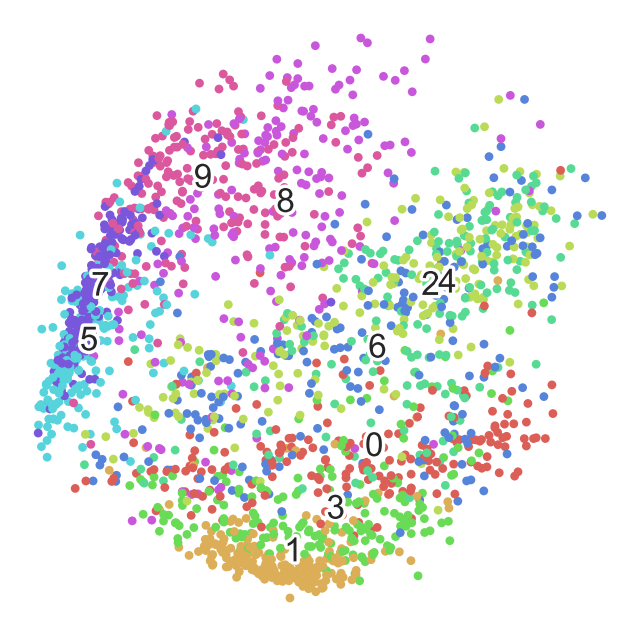

In [12]:
top_two_comp = pca_df[['pca1','pca2']] # taking first and second principal component

fashion_scatter(top_two_comp.values,y_subset) # Visualizing the PCA output

**Actividad 2** Juzga sobre la separabilidad de los grupos creados

<font color='blue'>
No se puede decir que los grupos no estén separados, pero sí que se puede decir que la agrupación no es buena ya que los diferentes clusters se entrelazan entre sí, además de los muchísimos puntos dispersos que hay.

</font>

Vamos a visualizar, como en la práctica anterior, la proyección 2D mostrando sobre ellos algunos puntos originales del dataset.
Usa la función 'plot_components' sobre los puntos transformados y el dataset original. Regula el parámetro 'thumb_frac' para decidir el número de puntos que muestras (fotos).

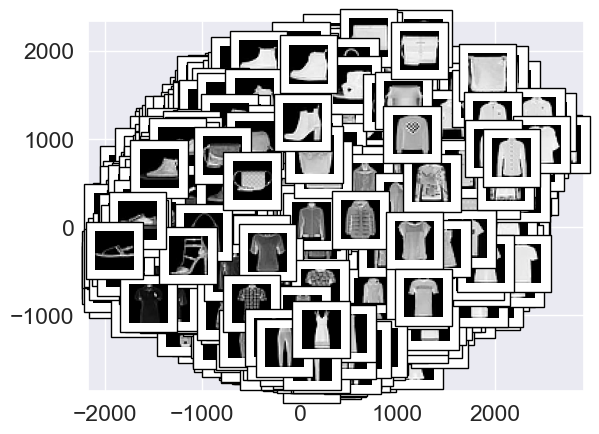

In [22]:
from matplotlib import offsetbox

plot_components(top_two_comp.values, x_subset, thumb_frac=0.001)

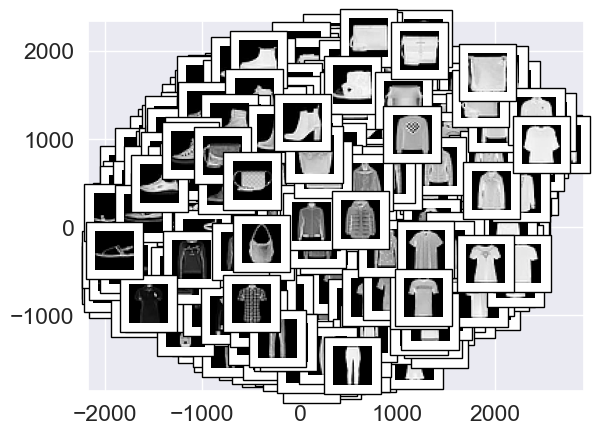

In [23]:
plot_components(top_two_comp.values, x_subset, thumb_frac=0.01)

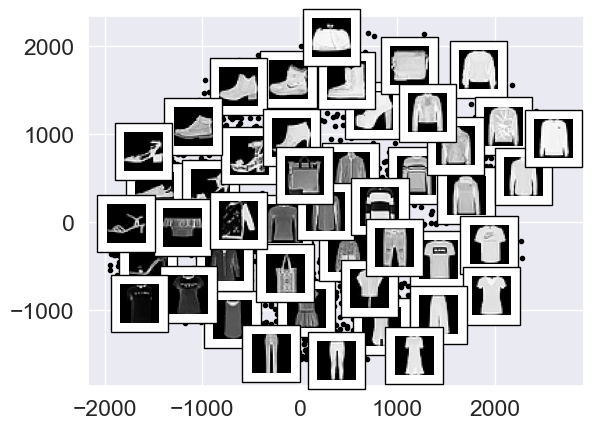

In [27]:
plot_components(top_two_comp.values, x_subset, thumb_frac=0.095)

Como puedes ver, PCA ha intentado (tu juzgarás el éxito) separar los diferentes puntos y formar clusters basados en la simularidad encontrada. EL gráfico obtenido puede usarse con finalidad exploratoria y las componentes principales encontradas pueden usarse como entrada a algún método de agrupamiento.

Vamos a probar ahora con otro método lineal: **Multi-Dimensional Scaling (MDS)**.
Aquí simplemente vamos a cargar MDS con n_components=2 para embeber en un espacio de 2D. Puedes probar con más configuraciones si lo deseas.

/var/folders/x6/j_qf3qyj06nf2nvm89970c0w0000gn/T/ipykernel_837/745979963.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])


(<Figure size 800x800 with 1 Axes>,
 <AxesSubplot:>,
 [Text(-1410.2340373966376, 427.09479951579124, '0'),
  Text(-798.1094871483308, 1753.8617321103784, '1'),
  Text(-1086.5854231219387, -1133.0598327105165, '2'),
  Text(-1131.1841670699275, 1231.0503078549252, '3'),
  Text(-1368.1526400846078, -1030.7319975296953, '4'),
  Text(1832.6130981212536, 1103.7513235284664, '5'),
  Text(-822.3807211758077, -205.70015072219502, '6'),
  Text(2017.7992362470266, 220.7159739138468, '7'),
  Text(524.5650199491972, -1412.311817060406, '8'),
  Text(1456.0844826890511, -1415.56485495435, '9')])

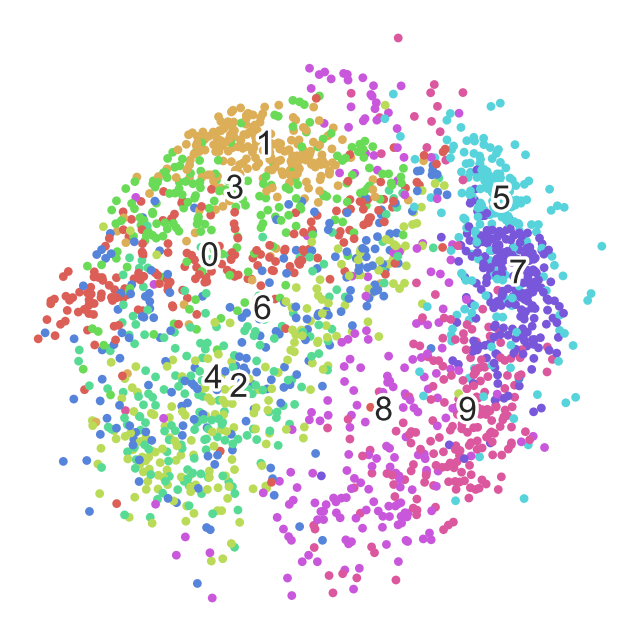

In [28]:
from sklearn.manifold import MDS
#prepara el modelo MDS
embedding = MDS(n_components=2)
Xmds_transformed = embedding.fit_transform(x_subset)
fashion_scatter(Xmds_transformed,y_subset)

**Actividad 3**. Observa los resultados de MDS y compáralos con los de PCA. Describe sus parecidos y diferencias.

<font color='blue'>
MDS agrupa mejor que PCA (pero tampoco mucho) y aunque menos que PCA también se produce solapamiento entre clúster. Sí que comentar que en MDS los grupos son más compactos y en PCA más esparcidos.
    
    

En lo referente a los tiempos, PCA es muy superior, siendo prácticamente instantáneo frente a MDS que tarda muchísimo. 
</font>

Vamos a hora a trabajar con t-NSE. Prepara el modelo para cambiar explícitamente los atributos: perplexity, num iteraciones, early_exageration,learning_rate, n_iter_without_progress
Puedes primero preparar el modelo por defecto

In [29]:
from sklearn.manifold import TSNE
import time
time_start = time.time()
#prepar el modelo aqui coloca un random_state = RS
modelo_tsne = TSNE(random_state = RS)
fashion_tsne = modelo_tsne.fit_transform(x_subset)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/Users/mariacaveromartinez/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/mariacaveromartinez/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE done! Time elapsed: 4.726089954376221 seconds


Nota como t-SNE toma un tiempo mucho mayor que PCA o MDS
Vamos a visualizar la salida de t-SNE usando la función fashion_scatter()


/var/folders/x6/j_qf3qyj06nf2nvm89970c0w0000gn/T/ipykernel_837/745979963.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])


(<Figure size 800x800 with 1 Axes>,
 <AxesSubplot:>,
 [Text(-11.5146675, 27.458382, '0'),
  Text(30.681026, 35.51119, '1'),
  Text(-38.83513, -1.8433645, '2'),
  Text(5.997906, 29.442883, '3'),
  Text(-37.94648, 5.772547, '4'),
  Text(21.659933, -15.289751, '5'),
  Text(-21.053602, 3.659916, '6'),
  Text(38.550846, -21.586647, '7'),
  Text(-21.254541, -29.403847, '8'),
  Text(10.432144, -42.851578, '9')])

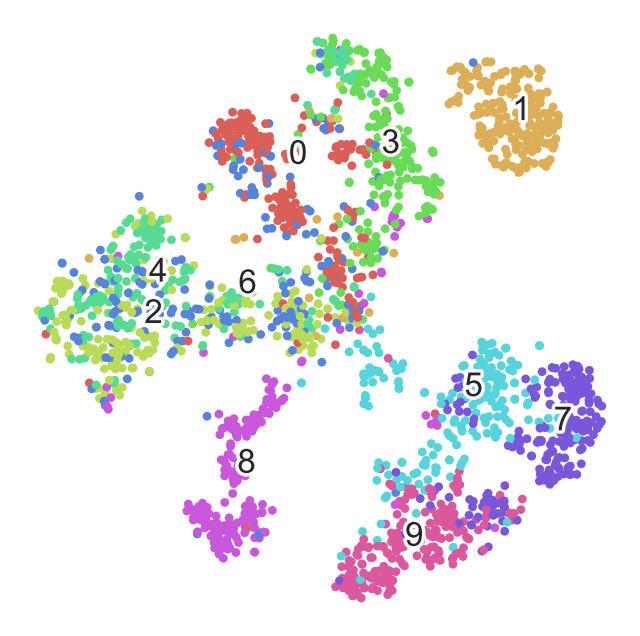

In [30]:
fashion_scatter(fashion_tsne, y_subset)

Como puedes observar hay una gran diferencia (y mejora) en los agrupamientos que hace t-SNE. Puedes ver que muchos de los grupos correspondientes a artículos diferentes estan bastante bien separados.
Ahora seria el momento de usar algún algoritmo de clustering para realizar agrupamientos.


Vamos a visualizar ahora alguno de los contenidos en el espacio original de alguno de los puntos embebidos en el espacio 2D. Para ello usa la función plot_components() con un thumb_frac adecuado

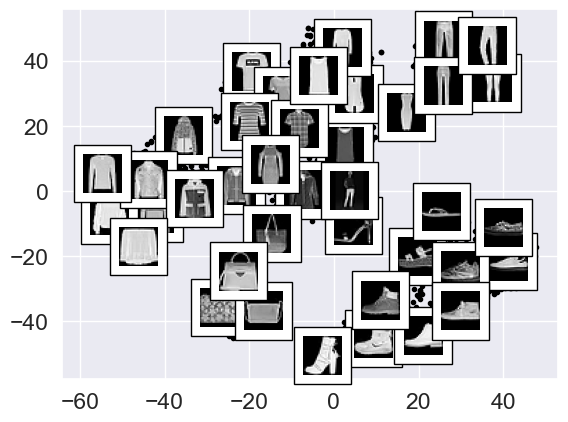

In [33]:
plot_components(fashion_tsne, x_subset, thumb_frac=0.095)

En la información de TSNE de la libreria scikit se indica que:

"It is highly recommended to use another dimensionality reduction method (e.g., PCA for dense data or TruncatedSVD 
for sparse data) to reduce the number of dimensions to a reasonable amount (e.g., 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples."

Vamos a seguir esta recomendación y vamos a reducir el número de dimensiones usando PCA antes de alimentar TSNE con la base de datos resultante de esta transformación.
Usa pca para crear una base de datos de 50 dimensiones. Usaremos luego ese dataset para alimentar TSNE.


In [34]:
time_start = time.time()

#modelo de PCA con 50 componentes principales
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(x_subset)

print('PCA with 50 components done! Time elapsed: {} seconds'.format(time.time()-time_start))

print('Cumulative variance explained by 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

PCA with 50 components done! Time elapsed: 0.1202399730682373 seconds
Cumulative variance explained by 50 principal components: 0.8720520741174493


Aplica esta base de datos a TSNE

In [35]:
import time
time_start = time.time()


modelo_tsne = TSNE(learning_rate = 100,
                       perplexity = 10,
                       n_iter = 250,
                       early_exaggeration = 12,
                       n_iter_without_progress = 250,
                       random_state = RS)

fashion_pca_tsne = modelo_tsne.fit_transform(pca_result_50)
#print 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start)

/Users/mariacaveromartinez/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Nota que el tiempo de computación se ha reducido bastante.

Visualizando:


/var/folders/x6/j_qf3qyj06nf2nvm89970c0w0000gn/T/ipykernel_837/745979963.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])


(<Figure size 800x800 with 1 Axes>,
 <AxesSubplot:>,
 [Text(-1.9973112, 0.30531606, '0'),
  Text(-1.2358402, 3.1815186, '1'),
  Text(-2.2172668, -1.5066093, '2'),
  Text(-1.4633803, 1.2376101, '3'),
  Text(-2.2270656, -1.2582755, '4'),
  Text(2.7735357, -0.70312905, '5'),
  Text(-2.03725, -0.5414872, '6'),
  Text(3.5384681, -1.0077115, '7'),
  Text(0.8883004, -1.688878, '8'),
  Text(2.9680576, 0.8849595, '9')])

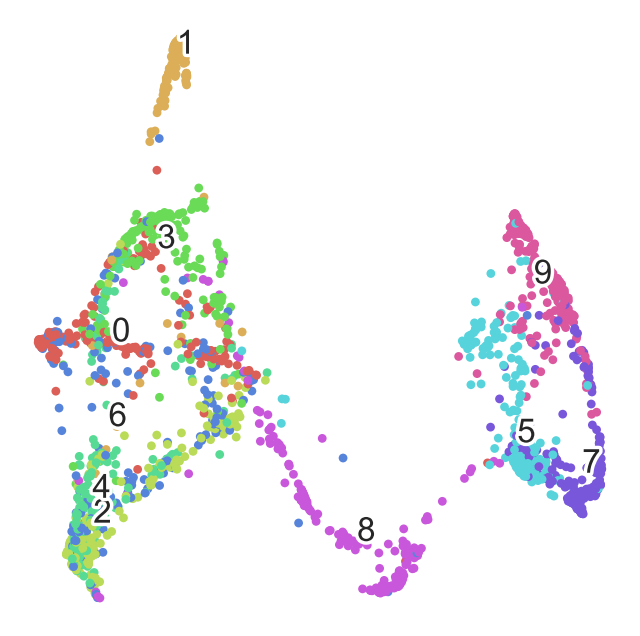

In [36]:
fashion_scatter(fashion_pca_tsne, y_subset)

In [37]:
model_tsme_2 = TSNE(learning_rate = 50,
                       perplexity = 10,
                       n_iter = 1000,
                       early_exaggeration = 12,
                       n_iter_without_progress = 250,
                       random_state = RS)

fashion_pca_tsne_2 = model_tsme_2.fit_transform(pca_result_50)


/Users/mariacaveromartinez/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [38]:
model_tsme_3 = TSNE(learning_rate = 10,
                       perplexity = 10,
                       n_iter = 1000,
                       early_exaggeration = 12,
                       n_iter_without_progress = 250,
                       random_state = RS)

fashion_pca_tsne_3 = model_tsme_3.fit_transform(pca_result_50)


/Users/mariacaveromartinez/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [39]:
model_tsme_4 = TSNE(learning_rate = 50,
                       perplexity = 1000,
                       n_iter = 1000,
                       early_exaggeration = 12,
                       n_iter_without_progress = 250,
                       random_state = RS)

fashion_pca_tsne_4 = model_tsme_4.fit_transform(pca_result_50)


/Users/mariacaveromartinez/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [40]:
print( "model_tsme --> " , modelo_tsne.kl_divergence_)
print( "model_tsme_2 --> " , model_tsme_2.kl_divergence_)
print( "model_tsme_3 --> " , model_tsme_3.kl_divergence_)
print( "model_tsme_4 --> " , model_tsme_4.kl_divergence_)

model_tsme -->  1.7976931348623157e+308
model_tsme_2 -->  1.0355807542800903
model_tsme_3 -->  1.1307255029678345
model_tsme_4 -->  0.08684782683849335


Ejecuta varias veces t-SNE imprimiendo el valor de la divergencia KL. Esto deberia de darte una pista sobre qué resultado es el mejor.

Visualiza una ejecución de t-SNE como has hecho con PCA usando plot_components()

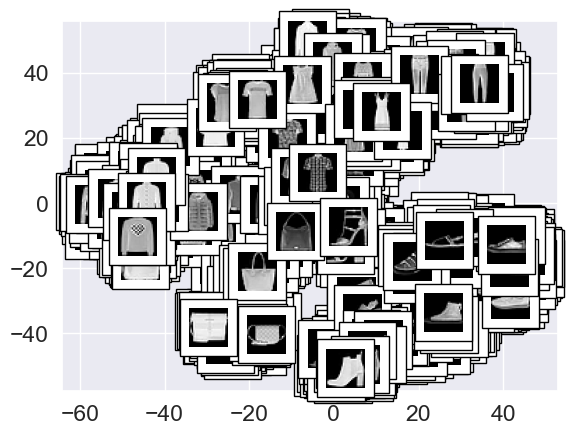

In [41]:
plot_components(fashion_tsne, x_subset, thumb_frac=0.001)

**Actividad 4** Comenta los resultados tras reducir la dimensionalidad con PCA. ¿Ha mejorado el resultado? ¿Si lo ha hecho, en qué sentido? ¿Has necesitado pasar mucho tiempo ajustando parámetros? ¿Qué parámetro resulta más sensible sobre t-SNE?

<font color='blue'>
En el modelo con PCA, debido a la limitación de la linealidad el resultado ha mejorado notablemente.

No se ha necesitado demasiado tiempo para ajustando parámetros.

Los dos hiperparámetros más relevantes son el **learning_rate** y la **perplexity**.
    
<font>